# Example: Profit Diagram and Breakeven Points for a Short Strangle
A short strangle involves selling a `call` and `put` option on the same underlying stock, where both legs have the same expiration date. This example will familiarize students with computing the payoff, profit, and breakeven points for a short strangle at expiration.

## Learning objectives
* __Prerequisites__: load the option chain data for `62-DTE` contracts on [Micron Technology](https://www.micron.com/about), which has the ticker symbol `MU.`
*  __Task 1__: Select the strike prices for the `call` and `put` legs of the short strangle trade.
*  __Task 2__: Build contract models for the short `call` and `put` contract legs, and compute the payoff, profit, and breakeven values

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites
We'll build our short strangle using options chain data for `62-DTE` contracts on [Micron Technology](https://www.micron.com/about), which has the ticker symbol `MU.` 
* Load the options chain dataset by calling the `MyOptionsChainDataSet()` function, which returns the pricing data as a `DataFrame` instance, which is exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). Let's save the options data in the `dataset::DataFrame` variable:

In [5]:
dataset = MyOptionsChainDataSet()

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,32.5,0.5912,46.9,47.22,47.55,49.16,0,2,0.99881,0.6458,Call
2,35.0,0.5597,44.4,44.8,45.2,39.75,0,1,0.99364,0.8463,Call
3,37.5,0.5283,41.95,42.33,42.7,0.0,0,0,0.99303,0.784,Call
4,40.0,0.4969,39.5,39.9,40.3,46.57,0,24,0.98822,0.7904,Call
5,42.5,0.4654,36.9,37.35,37.8,43.15,0,1,0.99424,0.6253,Call
6,45.0,0.434,34.55,34.88,35.2,37.85,0,27,0.9936,0.5769,Call
7,47.5,0.4025,32.15,32.5,32.85,30.35,0,85,0.98231,0.6363,Call
8,50.0,0.3711,29.65,30.03,30.4,30.35,2,65,0.95655,0.7286,Call
9,55.0,0.3082,24.85,25.2,25.55,25.69,30,377,0.96381,0.5384,Call


## Task 1: Select the strike prices for the `call` and `put` legs of the strangle
Let the `put` leg of the stangle have index `1`, and the `call` leg have index `2`. For a short strangle, the strike price of the `put` leg $K_{1}$ is less than the strike price of the `call` leg $K_{2}$, but the current share price $S_{\circ}$ is in between the strikes, i.e., $K_{1}<S_{\circ}<K_{2}$.
* The share price of `MU` is $S_{o}$ = `79.50 USD/share` for this options chain. Set this value in the `Sₒ` variable:

In [7]:
Sₒ = 79.50; # USD/share

Now, let's select random strike prices for the `put` and `call` legs such that the inequality is true. Filter `dataset` to find the `put` contracts with $K_{1}<S_{\circ}$. To do this, we'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping)

In [9]:
put_contracts = filter(:Type=>x->x == "Put", dataset) |> y -> filter(:Strike=> x-> (x < Sₒ && x> 0.80*Sₒ), y)

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,65.0,-0.1824,0.74,0.78,0.81,0.78,2,"2,156",-0.10551,0.4368,Put
2,67.5,-0.1509,1.07,1.1,1.13,1.13,23,"1,324",-0.14498,0.428,Put
3,70.0,-0.1195,1.53,1.56,1.58,1.62,614,"4,069",-0.19147,0.4149,Put
4,72.5,-0.0881,2.13,2.16,2.18,2.21,865,"2,992",-0.24963,0.407,Put
5,75.0,-0.0566,2.9,2.93,2.96,2.97,559,"3,034",-0.31662,0.4005,Put
6,77.5,-0.0252,3.85,3.9,3.95,4.0,456,"4,873",-0.39082,0.3954,Put


Select a random contract from the `put_contracts` collection; this will be our first leg of the strangle. Save this data in the `put_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [11]:
number_of_put_contracts = nrow(put_contracts)
put_leg_data = put_contracts[rand(1:number_of_put_contracts),:]

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
2,67.5,-0.1509,1.07,1.1,1.13,1.13,23,"1,324",-0.14498,0.428,Put


Do the same procedure, but now for the `call` contracts; save the data for the random `call` contract in the `call_leg_data` variable (which is also type  type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow)):

In [13]:
call_contracts = filter(:Type=>x->x == "Call", dataset) |> y -> filter(:Strike=> x-> (x > Sₒ && x < 1.2*Sₒ), y)
number_of_call_contracts = nrow(call_contracts)
call_leg_data = call_contracts[rand(1:number_of_call_contracts),:]

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,Delta,IV,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
7,95.0,-0.195,1.07,1.12,1.16,1.16,103,"7,270",0.17495,0.4049,Call


## Task 2: Build contract models and compute the payoff, profit, and breakeven values
Now that we have data for the contracts, we can compute the composite payoff, profit, and breakeven values for the short strange constructed from the randomly selected `put` and `call` legs.

* First, create `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models, initialized using the data from the random contracts from `Task 1`. Then, these contract models and possible share prices at expiration are passed to the `payoff(...)` function, which computes the individual and composite payoff and profit values.

Let's start with the randomly selected `put` contract. 

In [16]:
put_contract_model = build(MyAmericanPutContractModel, (
        K = put_leg_data[:Strike], 
        premium = put_leg_data[:Mid],
        sense = -1, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1));

Similarly, we construct the `call` contract model.

In [18]:
call_contract_model = build(MyAmericanCallContractModel, (
        K = call_leg_data[:Strike], 
        premium = call_leg_data[:Mid],
        sense = -1, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1));

Next, let's create an array of values for the share price at expiration. Make a vector of perturbation values $\beta_{i}\in\beta$, which we use to perturb the initial share price value $S_{\circ}$.
* Create a perturbation vector $\beta_{i}\in\beta$ which holds values $\beta_{i}\in\left[0.8.1.2\right]$. We'll use these values to perturb or compute various things, e.g., possible share prices at expiration for `MU`. We'll generate `1001` possible perturbations between `0.5` and `1.5`.

In [20]:
β = range(0.70,stop=1.3,length=1001) |> collect;

Now, create an array holding possible share prices at expiration by perturbing the initial share price. 
* Store these values in the `share_price_array` variable. For compactness, let's use the [Array comprehension functionality provided by Julia](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) to populate `share_price_array`.

In [22]:
share_price_array = [βᵢ*Sₒ for βᵢ ∈ β];

Finally, let's compute the payoff and profit for the short strangle. We compute the profit by calling the `profit(...)` function and save the profit values in the `profit_array` variable.
* The `profit_array` will be a `1001`$\times$ `4` array, in which each row is a possible value for the share price at expiration $S(T)$. Column `1` holds the possible $S(T)$ values, column `2` holds the profit for the short `put,` column `3` holds the profit for the short `call`, and column `4` holds the overall profit for the composite trade.

In [24]:
profit_array = profit([put_contract_model, call_contract_model], share_price_array)

1001×4 Matrix{Float64}:
  55.65    -10.75     1.12    -9.63
  55.6977  -10.7023   1.12    -9.5823
  55.7454  -10.6546   1.12    -9.5346
  55.7931  -10.6069   1.12    -9.4869
  55.8408  -10.5592   1.12    -9.4392
  55.8885  -10.5115   1.12    -9.3915
  55.9362  -10.4638   1.12    -9.3438
  55.9839  -10.4161   1.12    -9.2961
  56.0316  -10.3684   1.12    -9.2484
  56.0793  -10.3207   1.12    -9.2007
  56.127   -10.273    1.12    -9.153
  56.1747  -10.2253   1.12    -9.1053
  56.2224  -10.1776   1.12    -9.0576
   ⋮                          
 102.825     1.1     -6.7053  -5.6053
 102.873     1.1     -6.753   -5.653
 102.921     1.1     -6.8007  -5.7007
 102.968     1.1     -6.8484  -5.7484
 103.016     1.1     -6.8961  -5.7961
 103.064     1.1     -6.9438  -5.8438
 103.111     1.1     -6.9915  -5.8915
 103.159     1.1     -7.0392  -5.9392
 103.207     1.1     -7.0869  -5.9869
 103.255     1.1     -7.1346  -6.0346
 103.302     1.1     -7.1823  -6.0823
 103.35      1.1     -7.23    -6.13

`Unhide` the code below to see how we visualized the profit and break-even points for the short-stangle.

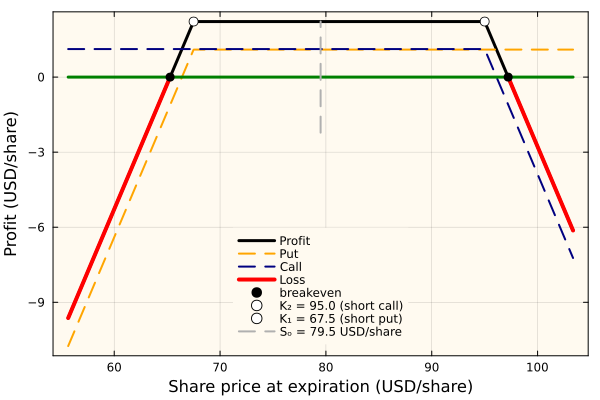

In [26]:
let

    K₁ =  put_leg_data[:Strike];
    K₂ = call_leg_data[:Strike];
    premium_1 = put_leg_data[:Mid]
    premium_2 = call_leg_data[:Mid]
    max_profit = (premium_1 + premium_2);
    S = share_price_array
    number_of_steps = length(S);
    BEL = zeros(length(S))

    profit_idx = findall(>(0), profit_array[:,4])
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent,
        legend=:bottom)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash, c=:orange)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash, c=:navyblue)
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
    
    plot!(S,BEL,lw=3, c=:green, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven", ms=5)
    
    scatter!([K₂],[max_profit], ms=5, label = "K₂ = $(K₂) (short call)", msc=:black, mc=:white)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short put)", msc=:black, mc=:white)
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.